In [1]:
import csv
import numpy as np
import logging
import matplotlib.pyplot as plt
from imp import reload
reload(logging)

<module 'logging' from 'D:\\Anaconda3\\lib\\logging\\__init__.py'>

# Data Preparation
Use csv library to extract the data row by row in the csv file. A data entry is considered as corrupted if one of the columns is corrupted as 'X' or empty, or a 4th column appears in the entry. From the following result we can see the data corruption ratio is 20.1012%, which is a fairly large portion of data.

In [2]:
with open('task_data_small.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    total_count = 0 # count the total number of entries
    corrupt_count = 0 # count the number of corrupted data
    corrupt_ratio = 0 # the ratio of corrupted data
    
    for row in csv_reader:
        total_count += 1
        if len(row)!=3: # an extra column appears
            corrupt_count += 1
        elif row[0]=='' or row[1]=='' or row[2]=='' or row[0]=='X' or row[1]=='X' or row[2]=='X': # data corruption within three columns 
            corrupt_count += 1
    
    corrupt_ratio = corrupt_count / total_count
    print("The data corruption ratio is: "+str(corrupt_ratio*100)+"%")

The data corruption ratio is: 20.1012%


# Anomaly Detection by Moving Average
 
First, let's implement a detector by using the moving average method. The corrupted data is ignored by the detector and a corresponding message will be printed to standard output. The rest of the data entries, which are not corrupted, are used to compute moving averages for each individual account. A transaction is marked as anomalous if the transaction amount deviates from the current moving average by 3 standard deviations (std).

In [3]:
%%capture

reload(logging)
logging.basicConfig(filename='anomaly_average_final.log', filemode='w', level=logging.DEBUG)
with open('task_data_small.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    
    merchant_dict = {} # store the merchant ID under each account
    amount_dict = {} # store the transaction amount for corresponding merchant ID under each account
    mean_dict = {} # store the moving average under each account
    std_dict = {} # store the moving standard deviation under each account
    anomaly_dict = {} # store the index of anomaly transactions under each account
    account_count_dict = {} # count the number of uncorrupted transactions under rach account
    
    anomaly_count = 0 # count the total number of anomalies
    
    for row in csv_reader:
        print("====================")
        
        # first ensure only the data that is not corrupted is processed
        if len(row)==3 and row[0]!='' and row[1]!='' and row[2]!='' and row[0]!='X' and row[1]!='X' and row[2]!='X': 
            account = row[0].strip() # account ID
            merchant = row[1].strip() # merchant ID
            amount = float(row[2]) # transaction amount
            print("Account: "+account)
            print("Merchant: "+merchant)
            print("Transaction amount: "+row[2])
            
            # current account appeared before
            if account in merchant_dict:
                current_mean = mean_dict[account][-1]
                current_std = std_dict[account][-1]
                diff = amount - current_mean
                
                account_count_dict[account] += 1
                
                merchant_dict[account].append(merchant)
                amount_dict[account].append(amount)

                new_mean = np.mean(amount_dict[account])
                new_std = np.std(amount_dict[account])
                mean_dict[account].append(new_mean)
                std_dict[account].append(new_std)
                print("Mean of transaction amount so far: "+str(new_mean))
                print("Std of transaction amount so far: "+str(new_std))
                
                # there is only one transaction for the current account, or the current transaction is not flagged up
                # because it does not deviate from the current mean for more than 3 std
                if (len(std_dict[account])==2 and current_std==0) or (diff>=-3*current_std and diff<=3*current_std):
                    print("Status: normal")
                    
                
                # current transaction is flagged up because it deviates from the current mean for more than 3 std
                else:
                    anomaly_count += 1
                    
                    if account in anomaly_dict:
                        anomaly_dict[account].append(account_count_dict[account])
                    else:
                        anomaly_dict[account]=[account_count_dict[account]]
                    
                    #logging.basicConfig(filename='anomaly5.log',level=logging.DEBUG)
                    logging.warning('Flag: '+'account: '+account+' merchant: '+merchant+' amount: '+str(amount))
                    print("Status: abnormal. The event has been recorded in log file.")
                    
            
            # first time seeing the current account
            else:
                print("Mean of transaction amount so far: "+str(amount))
                print("Std of transaction amount so far: 0")
                print("Status: normal")
        
                merchant_dict[account] = [merchant]
                amount_dict[account] = [amount]
                mean_dict[account] = [amount]
                std_dict[account] = [0]
                
                account_count_dict[account]=0
        
        # corrupted data
        else:
            account = row[0].strip() # account ID
            merchant = row[1].strip() # merchant ID
            print("Account: "+account)
            print("Merchant: "+merchant)
            print('The data of this transaction is corrupted' )

# Analysis
The graph of uncorrupted transaction amounts of an individual account can be shown below. The red points indicate the anomalies. If there is no red points for an account, it means all the transactions of the account is recorded as normal using the current algorithm. If you wish to check for a specific account, simply replace the account number in the first line below. 

As we can see from the following graph, the anomaly detection technique we are using here: moving average, does not perform very good. For example, the 3rd and 4th uncorrupted transactions made by account 255046487 are marked as anomalies, however, if the 4th transaction is an anomaly, the 6th transaction should also be an anomaly. Meanwhile, the 3rd transaction is actually not far from the final global average, thus in my opinion, it should not be marked as an anomaly. This shows two problems of the moving average approach:
- Generally speaking, moving average is able to capture the overall trend of the time series data, but it can also be affected by anomalous data because the anomalies are also averaged into the trend.

- The moving average method is not very reliable when it has seen very few transactions at the begining.

In [14]:
print('There are '+str(anomaly_count)+' anomalies recorded.') # number of anomalies recorded

There are 16572 anomalies recorded.


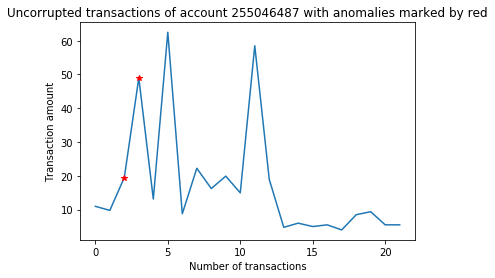

In [10]:
account = '255046487'
plt.plot(amount_dict[account]) # print all the transactions 
plt.title('Uncorrupted transactions of account '+account+' with anomalies marked by red')
plt.xlabel('Number of transactions')
plt.ylabel('Transaction amount')
if account in anomaly_dict: # if the account has anomalies, mark them by red points
    for i in range(len(anomaly_dict[account])):
        plt.plot(anomaly_dict[account][i], amount_dict[account][anomaly_dict[account][i]], 'r*')

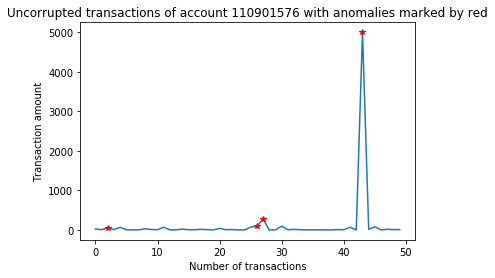

In [4]:
account = '110901576'
plt.plot(amount_dict[account]) # print all the transactions 
plt.title('Uncorrupted transactions of account '+account+' with anomalies marked by red')
plt.xlabel('Number of transactions')
plt.ylabel('Transaction amount')
if account in anomaly_dict: # if the account has anomalies, mark them by red points
    for i in range(len(anomaly_dict[account])):
        plt.plot(anomaly_dict[account][i], amount_dict[account][anomaly_dict[account][i]], 'r*')